In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from sklearn.metrics import f1_score
plt.style.use('science')

In [6]:
pos_colors = {
    "noun": "C0",
    "verb": "C1",
    "adjective": "C2",
    "adverb": "C3",
    "all": "black",
}

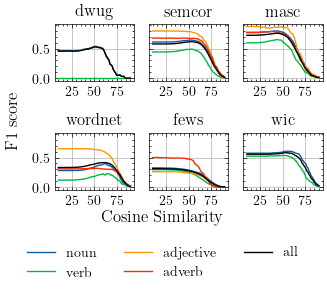

In [32]:
fig, axis = plt.subplots(2, 3, sharey=True)#, figsize=(6, 5))
axis = axis.flatten()
types = ["noun", "verb", "adjective", "adverb", "all"]

for idx, exp in enumerate(["dwug", "semcor", "masc", "wordnet", "fews", "wic"]):
    all_data = []
    for pos in types:
        if pos == "all":
            data = pd.concat(all_data)
        else:
            data = pd.read_json(f"output/bert/{exp}.{pos}.predict.json", lines=True)
            data["pos"] = pos
            all_data.append(data)
        if not data.shape[0]:
            continue
        x = []
        y = []
        for i in np.linspace(10, 90, 100):
            data["pred"] = "different"
            data.loc[data.score > i, "pred"] = "identical"
            x.append(i)
            y.append(f1_score(data.LABEL.values, data.pred.values, pos_label='identical'))
        label = pos if idx == 0 else None
        axis[idx].plot(x, y, color=pos_colors[pos])
        axis[idx].set_title(exp)
        axis[idx].grid(True)
handles = [plt.Line2D([0], [0], color=color, label=pos) for pos, color in pos_colors.items()]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)

fig.supxlabel("Cosine Similarity", y=0.1) 
fig.supylabel("F1 score", x=0.05)

plt.tight_layout()
plt.savefig("semdiff.pdf")

In [33]:
# deepseek 0.6642857142857143
# bert embedding distance 0.6112997194408463


data["pred"] = "different"
data.loc[data.score > 70, "pred"] = "identical"
sum(data.LABEL == data.pred)/data.shape[0]

0.5935714285714285

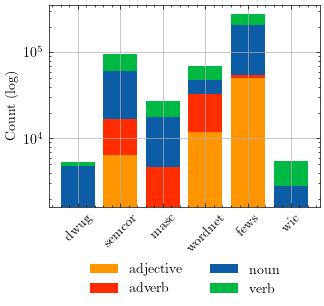

In [34]:
datasets = {}
for idx, exp in enumerate(["dwug", "semcor", "masc", "wordnet", "fews", "wic"]):
    data = pd.read_json(f"data/{exp}.train.json").groupby("POS").count()["LEMMA"]
    datasets[exp] = data.to_dict()

# Extract POS tags and dataset names
pos_tags = sorted({tag for tags in datasets.values() for tag in tags})
dataset_names = list(datasets.keys())

# Prepare data for stacking
data = {tag: [] for tag in pos_tags}
for ds in dataset_names:
    for tag in pos_tags:
        data[tag].append(datasets[ds].get(tag, 0))

# Plot
fig, ax = plt.subplots()
bottom = np.zeros(len(dataset_names))
ax.grid(True)

for tag in pos_tags:
    ax.bar(dataset_names, data[tag], label=tag, bottom=bottom, color=pos_colors[tag])
    bottom += np.array(data[tag])
    

ax.set_yscale("log")
ax.set_ylabel("Count (log)")

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5), ncol=2)
plt.xticks(rotation=45)
plt.savefig("semdist.pdf")